# Import Required Libraries

In [ ]:
%pip install pandas scikit-learn numpy sqlite3 matplotlib

In [64]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from calculate_pvs import calculate_pvs

# Database Connection Setup
Set up the connection to the SQLite database and create the necessary tables if they do not exist.

In [60]:
# Connect to the database
conn = sqlite3.connect('premier_league.db')

# Query to get passing statistics along with player names
# query = '''
# SELECT ms.player_id, p.name as player_name, ms.pass_success, ms.pass_cross_accurate, ms.pass_long_ball_accurate, ms.pass_through_ball_accurate, ms.minutes_played
# FROM match_statistics ms
# JOIN players p ON p.playerId = ms.player_id
# '''
query = '''
SELECT ms.player_id, p.name as player_name, ms.rating, ms.goals, ms.assists, ms.shots, ms.key_passes, ms.dribble_won,
       ms.tackles, ms.interceptions, ms.clearances, ms.blocks, ms.aerials_won, 
       ms.total_passes, ms.pass_success, ms.pass_cross_accurate, ms.pass_long_ball_accurate, 
       ms.yellow_cards, ms.red_cards, ms.dispossessed, ms.turnovers, ms.own_goals,
       ms.minutes_played, ms.pass_through_ball_accurate
FROM match_statistics ms
JOIN players p ON p.playerId = ms.player_id
'''

# Load the data into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

To evaluate a player's value in a match based on their statistics, we can use a **weighted sum approach** that incorporates key performance metrics, using the **rating** as the primary reference point. The formula should consider offensive, defensive, and playmaking contributions, balancing them based on positional impact.

---

### **Formula: Player Value Score (PVS)**
$$PVS = \alpha \times \text{rating} + \beta \times (A) + \gamma \times (B) + \delta \times (C)$$
Where:
- **\(A\)** = Offensive contributions:  
  $$(goals \times 6) + (assists \times 4) + (shots \times 1) + (key\_passes \times 2) + (dribble\_won \times 1.5)$$
- **\(B\)** = Defensive contributions:  
  $$(tackles \times 1.5) + (interceptions \times 1.5) + (clearances \times 1.5) + (blocks \times 1.5) + (aerials\_won \times 1.5)$$
- **\(C\)** = Possession & Passing:  
  $$(total\_passes \times 0.1) + (pass\_success \times 1.5) + (pass\_cross\_accurate \times 1) + (pass\_long\_ball\_accurate \times 1)$$

Penalties for negative actions:
$$
PVS -= (yellow\_cards \times 2) + (red\_cards \times 5) + (dispossessed \times 0.5) + (turnovers \times 0.5) + (own\_goals \times 6)
$$

---

### **Weighting Factors**
- Rating is the key reference metric:
$$ \alpha = 10 $$ 
- Offensive stats contribute significantly:
$$ \beta = 1.5 $$  
- Defensive stats are crucial but less than offense:
$$ \gamma = 1.2 $$  
- Passing and possession contribute to overall value:
$$ \delta = 1 $$ 

This formula dynamically adapts to different player roles by emphasizing the **rating** while giving appropriate weight to contributions based on position and team tactics.

Would you like a Python function to compute this? 🚀

# Main Function Execution
## Step 2: Process the Data
Next, you need to process the data to prepare it for visualization. This might include handling missing values, aggregating data, etc.

In [ ]:
# Handle missing values (if any)
df.fillna(0, inplace=True)

# Convert all columns to numeric values except player_name
numeric_columns = df.columns.drop(['player_name'])
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Fill NaN values with 0 again after conversion
df.fillna(0, inplace=True)

df['PVS'] = df.apply(calculate_pvs, axis=1)

# Aggregate data by player_id and player_name
df_agg = df.groupby(['player_id', 'player_name']).agg({
    'pass_success': 'sum',
    'pass_cross_accurate': 'sum',
    'pass_long_ball_accurate': 'sum',
    'pass_through_ball_accurate': 'sum',
    'minutes_played': 'sum',
    'player_id': 'count',
    'PVS': 'mean',
    'rating': 'mean'
}).rename(columns={'player_id': 'matches_played'}).reset_index()

# Filter top 100 players by total minutes played
top_100_players = df_agg.nlargest(100, 'minutes_played')

# Calculate accuracy percentages
top_100_players['cross_accuracy'] = top_100_players['pass_cross_accurate']
top_100_players['pass_success_accuracy'] = (top_100_players['pass_success'] / top_100_players['matches_played'])
top_100_players['long_ball_accuracy'] = (top_100_players['pass_long_ball_accurate'] / top_100_players['matches_played'])
top_100_players['through_ball_accuracy'] = top_100_players['pass_through_ball_accurate']



## Step 3: Visualize the Data
Finally, use a visualization library to create charts. Here, we'll use Matplotlib and Seaborn.

## Ranking by passing accuracy

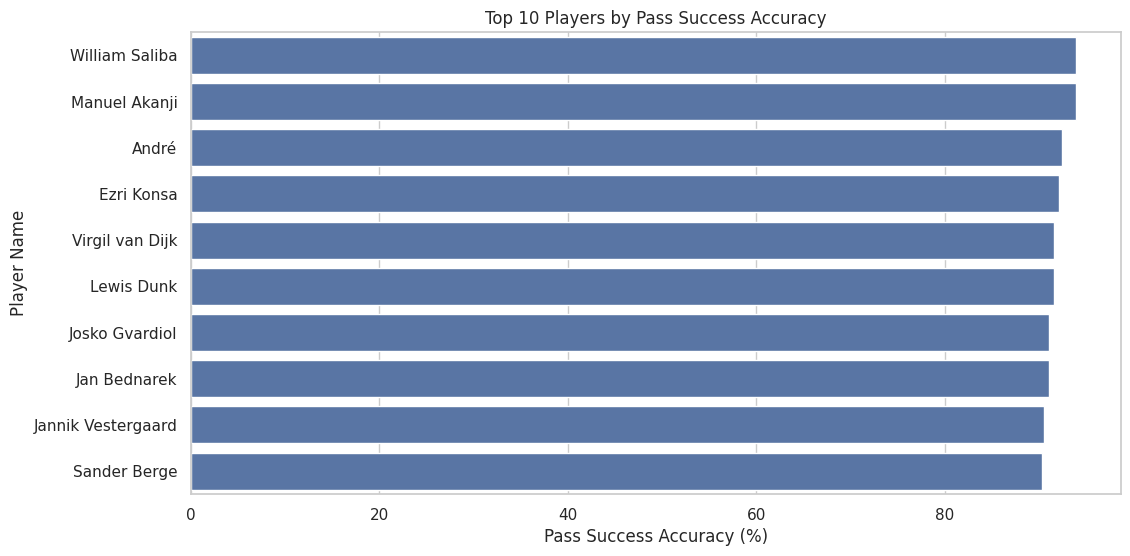

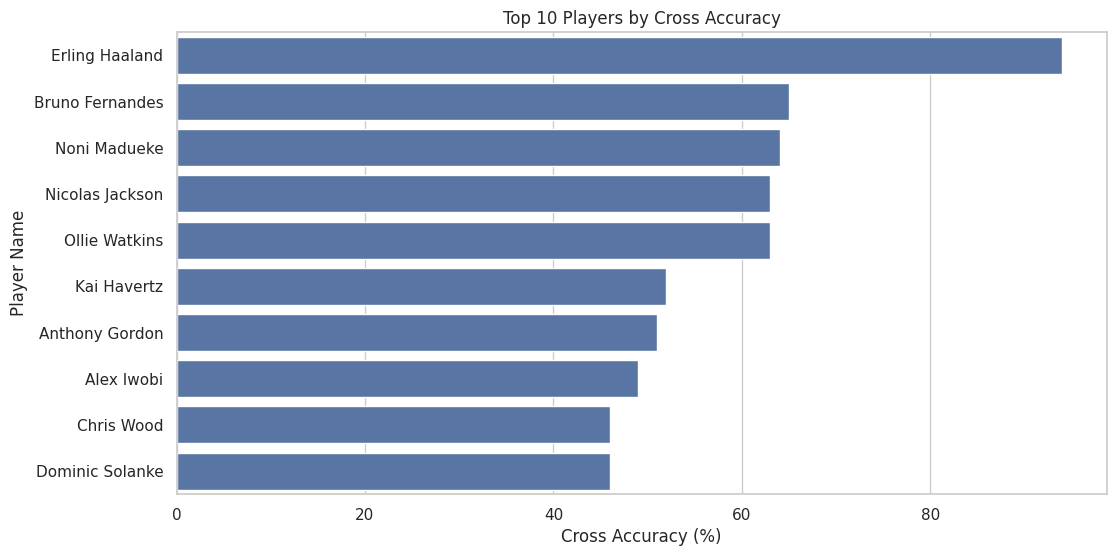

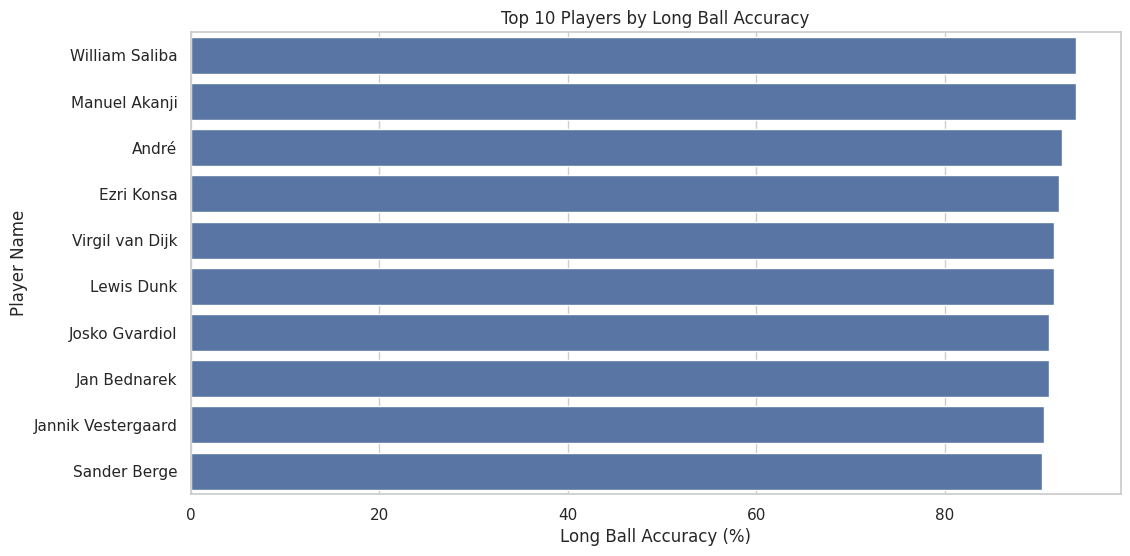

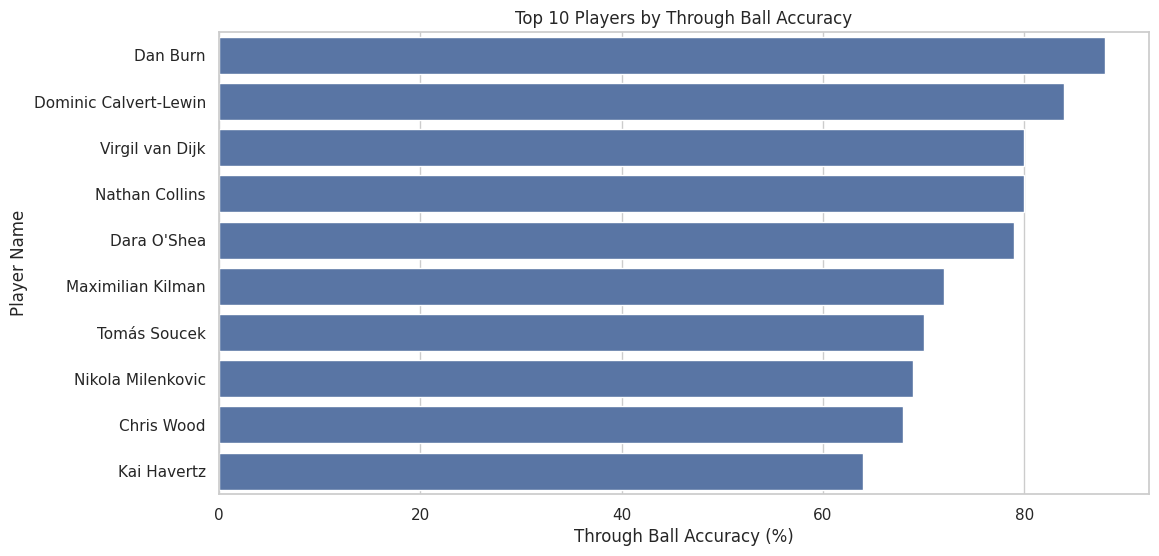

In [62]:
import seaborn as sns # type: ignore
# Set the style
sns.set(style="whitegrid")

# Create a bar plot for cross accuracy
top_10_pass_success_accuracy = top_100_players.nlargest(10, 'pass_success_accuracy')
plt.figure(figsize=(12, 6))
sns.barplot(y='player_name', x='pass_success_accuracy', data=top_10_pass_success_accuracy)
plt.title('Top 10 Players by Pass Success Accuracy')
plt.xlabel('Pass Success Accuracy (%)')
plt.ylabel('Player Name')
plt.show()

# Create a horizontal bar plot for cross accuracy
top_10_cross_accuracy = top_100_players.nlargest(10, 'cross_accuracy')
plt.figure(figsize=(12, 6))
sns.barplot(y='player_name', x='cross_accuracy', data=top_10_cross_accuracy, orient='h')
plt.title('Top 10 Players by Cross Accuracy')
plt.xlabel('Cross Accuracy (%)')
plt.ylabel('Player Name')
plt.show()

# Create a horizontal bar plot for long ball accuracy
top_10_long_ball_accuracy = top_100_players.nlargest(10, 'long_ball_accuracy')
plt.figure(figsize=(12, 6))
sns.barplot(y='player_name', x='long_ball_accuracy', data=top_10_long_ball_accuracy, orient='h')
plt.title('Top 10 Players by Long Ball Accuracy')
plt.xlabel('Long Ball Accuracy (%)')
plt.ylabel('Player Name')
plt.show()

# Create a horizontal bar plot for through ball accuracy
top_10_through_ball_accuracy = top_100_players.nlargest(10, 'through_ball_accuracy')
plt.figure(figsize=(12, 6))
sns.barplot(y='player_name', x='through_ball_accuracy', data=top_10_through_ball_accuracy, orient='h')
plt.title('Top 10 Players by Through Ball Accuracy')
plt.xlabel('Through Ball Accuracy (%)')
plt.ylabel('Player Name')
plt.show()

In [ ]:
# Standardize data for clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(top_100_players[['PVS', 'rating']])

# Apply K-Means Clustering
n_clusters = 3  # Define number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualize results
plt.figure(figsize=(8, 6))
plt.scatter(df['PVS'], df['rating'], c=df['Cluster'], cmap='viridis', edgecolors='k')
plt.xlabel('Player Value Score (PVS)')
plt.ylabel('Rating')
plt.title('K-Means Clustering of Player Value Scores and Ratings')
plt.colorbar(label='Cluster')
plt.show()

print(df[['player_name', 'PVS', 'rating', 'Cluster']])

KeyError: "['rating'] not in index"